In [1]:
import json
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import operator
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import imblearn.over_sampling as imb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
nations = ['Italy','England','France','Spain','European_Championship','World_Cup']

events = {}
events['England'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/events/events_England.json')
events['Italy'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/events/events_Italy.json')
events['France'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/events/events_France.json')
events['Spain'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/events/events_Spain.json')
events['European_Championship'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/events/events_European_Championship.json')
events['World_Cup'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/events/events_World_Cup.json')

matches = {}
matches['England'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/matches/matches_England.json')
matches['Italy'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/matches/matches_Italy.json')
matches['France'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/matches/matches_France.json')
matches['Spain'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/matches/matches_Spain.json')
matches['European_Championship'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/matches/matches_European_Championship.json')
matches['World_Cup'] = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/matches/matches_World_Cup.json')

teams = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/teams.json')

stadiums = pd.read_excel('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/Stadium field dimensions formatted.xlsx')


In [3]:
Englandshots = events['England']['eventName'] == 'Shot'
shots = events['England'][Englandshots]
all_matches = matches['England']
nationsnoEng = ['Italy','France','Spain','European_Championship','World_Cup']

for nation in nationsnoEng:
    all_matches = pd.concat([all_matches, matches[nation]])
    shotsbool = events[nation]['eventName'] == 'Shot'
    onlyshots = events[nation][shotsbool]
    shots = pd.concat([shots, onlyshots])

In [4]:
shots['x'] = [x[0]['x'] for x in shots['positions']]
shots['y'] = [x[0]['y'] for x in shots['positions']]

In [5]:
players = pd.read_json('/Users/lucastyler/Downloads/Senior Fall/DSCI 303/Project DSCI 303/players.json')

In [6]:
players['position'] = [x['name'] for x in players['role']]

In [7]:
playersprac = players[['firstName', 'lastName', 'height', 'weight', 'shortName', 'foot', 'wyId', 'position']]
shots = pd.merge(shots, playersprac, left_on = 'playerId', right_on = 'wyId')
len(shots)

36177

In [8]:
shots = shots[shots['position'] != 'Goalkeeper']

In [9]:
all_matches['Both_Teams'] = [tuple(x.keys()) for x in all_matches['teamsData']]

all_matches['Team1'] = [x[0] for x in all_matches['Both_Teams']]
all_matches['Team2'] = [x[1] for x in all_matches['Both_Teams']]

shots = pd.merge(shots, all_matches, left_on = 'matchId', right_on = 'wyId')

In [10]:
venues_formatted = []
for idx, row in shots.iterrows():
    if row['venue'] not in list(stadiums['Stadium']):
        venues_formatted.append('Default')
    else:
        venues_formatted.append(row['venue'])

In [11]:
shots['venues_formatted'] = venues_formatted

In [12]:
shots = pd.merge(shots, stadiums, left_on = 'venues_formatted', right_on = 'Stadium')
len(shots)

36174

In [13]:
#probably change this variable to distance_perc
shots['distanceperc'] = np.sqrt(np.power(shots["x"] - 100, 2) + np.power(shots["y"] - 50, 2))
#probably change this variable to distance_m
shots['distance_m'] = np.sqrt(np.power((0.01*shots["x"]*shots["Length"]) 
                                                  - shots["Length"], 2) + 
                                         np.power((0.01*shots["y"]*shots["Width"]) 
                                                  - (0.5*shots["Width"]), 2))

In [14]:
tagvalscol = []
for x in shots['tags']:
    tagvals = []
    for i in range(len(x)):
        tagvals.append(x[i]['id'])
    tagvalscol.append(tagvals)
shots['tagvals'] = tagvalscol

In [15]:
shots['goal'] = [1 if 101 in x else 0 for x in shots['tagvals']]

In [16]:
shots = pd.merge(shots, teams, left_on = 'teamId', right_on = 'wyId')

array([[<AxesSubplot:title={'center':'goal'}>]], dtype=object)

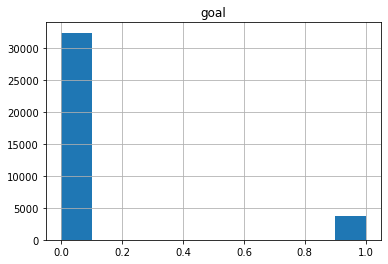

In [17]:
shots.hist('goal')

array([[<AxesSubplot:title={'center':'distance_m'}>]], dtype=object)

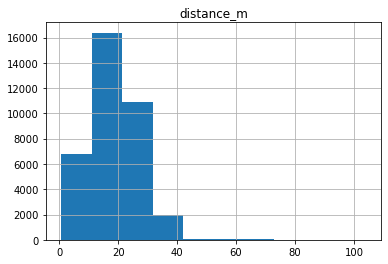

In [18]:
shots.hist('distance_m')

In [19]:
#add a column for the shot angle
#Looked at a few stadiums in Italy and they all had dimensions of 105*68m
angles = []
for idx, row in shots.iterrows():
    #If shooting from touchline, angle will be zero
    #continue to avoid divide by zero errors
    if row['x'] == 100:
        angles.append(0)
        continue
    #moving everything to left side of the field to make calculation easier
    if row['y'] > 50:
        mirror = 100 - row['y']
    else:
        mirror = row['y']
    #following four lines attempt to adjust to the actual field width and get 
    #more accurate positioning of the goal posts. e.g. Previously had right goal post at 
    #53.6 as opposed to most often at 54.64 which implicitly assumed width was 100 (which
    # is never the case). Thus, divide width by goal length to get percentage of field it takes up
    #and add half that percentage evenly to either side of 50
    goal_perc = (7.32/row['Width'])*100
    increment = goal_perc/2
    left_post = 50 - increment
    right_post = 50 + increment
    dist_a = ((row['x'] - 100)**(2))**(1/2)
    dist_b = ((mirror - right_post)**2)**(1/2)
    dist_c = ((mirror - left_post)**2)**(1/2)
    theta = np.arctan(dist_b/dist_a)*(180/math.pi)
    phi = np.arctan(dist_c/dist_a)*(180/math.pi)
    #Different cases for between the goalposts vs. to the left of a goalpost
    if mirror < left_post:
        angles.append(theta - phi)
    else:
        angles.append(theta + phi)
shots['angle'] = angles

array([[<AxesSubplot:title={'center':'angle'}>]], dtype=object)

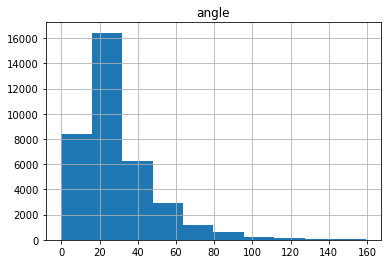

In [20]:
shots.hist('angle')

In [21]:
shots['foot_shot'] = ['right' if 402 in x else 'left' if 401 in x else 'head/body' for x in shots['tagvals']]

In [22]:
#1 means the player shot with their strong foot, 0 means they shot with their weak foot or
#with their head/body
strong_foot = []
header = []
for idx, row in shots.iterrows():
    if row['foot_shot'] == row['foot']:
        strong_foot.append(1)
    else:
        strong_foot.append(0)
    if row['foot_shot'] == 'head/body':
        header.append(1)
    else:
        header.append(0)

In [23]:
shots['strong_foot'] = strong_foot
shots['header'] = header

array([[<AxesSubplot:title={'center':'strong_foot'}>]], dtype=object)

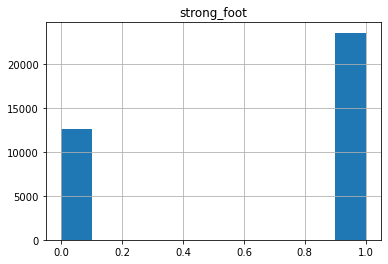

In [24]:
shots.hist('strong_foot')

In [25]:
print(len(shots[shots['strong_foot'] == 1]))
print(len(shots[shots['foot_shot'] == 'left']))
print(len(shots[shots['foot_shot'] == 'head/body']))

23585
11985
5847


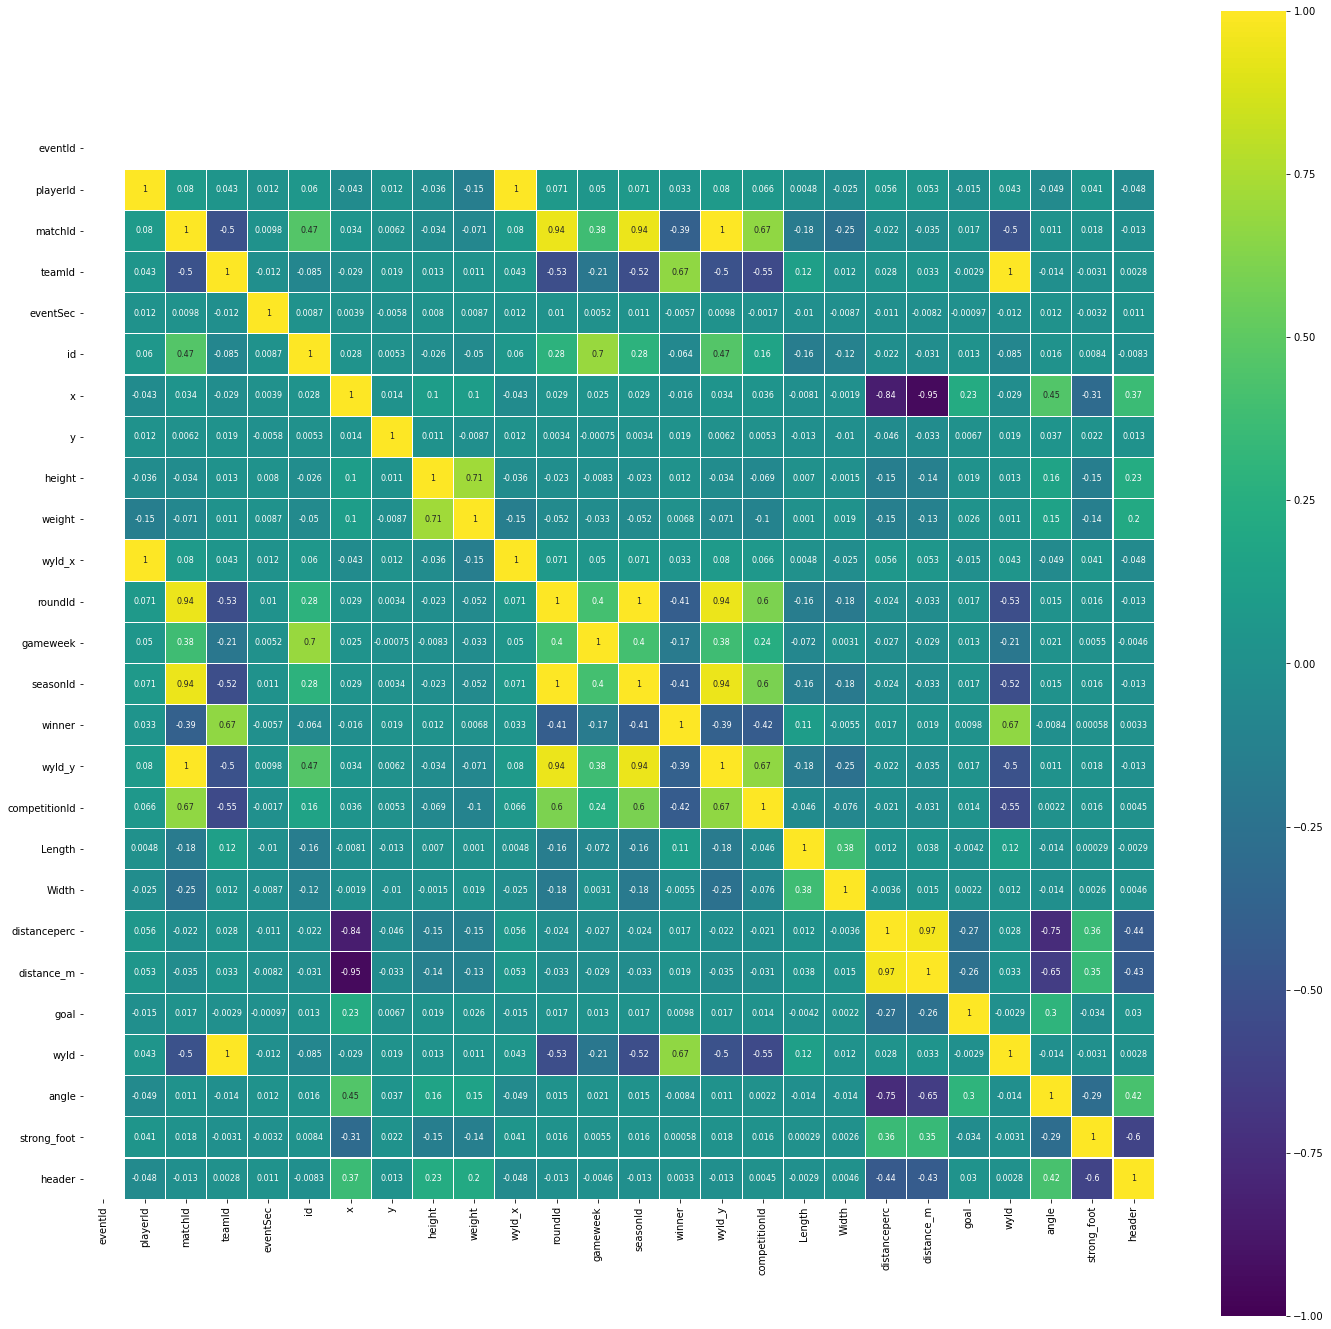

In [26]:
df_corr = shots.corr()
plt.figure(figsize=(24, 24))

sns.heatmap(df_corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [27]:
#procedure for creating dummy variables is the same as in the below column, can actually add it into the same for loop
#that being said, would there be an issue for adding in only two observations with goalkeeper shots where one is a
#goal? Might the algorithm think its extremely likely for goalkeepers to score when they're shooting when in fact this
#is just because of how few observations we have of goalkeepers shooting? Because of course we assume Forwards are
#most likely to score. But also, is this largely just because they shoot from the most advanced positions, at least
#from the view of the dataset?
positions = ['Forward', 'Midfielder', 'Defender']
for pos in positions:
    pos_shots = shots[shots['position'] == pos]
    goalsfrompos = pos_shots[pos_shots['goal'] == 1]
    perc_goals = len(goalsfrompos)/len(pos_shots)
    print('The percentage of successful shots from the', pos, 'position in this database is: ', perc_goals)

The percentage of successful shots from the Forward position in this database is:  0.13472133247918
The percentage of successful shots from the Midfielder position in this database is:  0.08015292776175464
The percentage of successful shots from the Defender position in this database is:  0.078868258178603


In [28]:
forward = []
midfielder = []
defender = []
for idx, row in shots.iterrows():
    if row['position'] == 'Forward':
        forward.append(1)
        midfielder.append(0)
        defender.append(0)
    elif row['position'] == 'Midfielder':
        forward.append(0)
        midfielder.append(1)
        defender.append(0)
    else:
        forward.append(0)
        midfielder.append(0)
        defender.append(1)

In [29]:
shots['F'] = forward
shots['MF'] = midfielder
shots['DEF'] = defender

In [30]:
#Add 45*60 seconds to every event in the second half, as eventSec tracks the number of seconds since
#the start of the current half
eventTime = []
for idx, row in shots.iterrows():
    if row['matchPeriod'] == '2H':
        eventTime.append(row['eventSec'] + (45*60))
    else:
        eventTime.append(row['eventSec'])

In [31]:
shots['eventTime'] = eventTime

In [32]:
shots[['x', 'y', 'angle']]

,x,y,angle
0,88,41,33.383357
1,87,48,44.175016
2,90,34,18.219757
3,81,33,18.228723
4,75,30,15.119733
...,...,...,...
36169,87,35,20.975259
36170,74,40,20.538964
36171,86,37,24.155710
36172,68,22,10.958475


In [33]:
y = shots['goal']
#weakfoot is base case for what foot the shot is, defender is base case for position group
X = shots[['distance_m', 'angle']]
dummies = np.asarray(shots[['strong_foot', 'header']])

In [34]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = np.append(X, dummies, axis = 1)

In [35]:
#should split before oversampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [36]:
# transform the dataset
oversample = imb.SMOTE(sampling_strategy = (1/2))
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [37]:
len(y_over[y_over == 1])/len(y_over)

0.3333241856252916

In [38]:
#Model fitted on untransformed dataset with apparently very low predictive power
xGmodel2 = LogisticRegression(random_state = 0).fit(X_train, y_train)
xGmodel2.coef_

array([[-1.07776227,  0.32499806,  0.09136644, -0.97190232]])

In [39]:
#accuracies of logistic regression on training, test set
print('Accuracy of logistic regression classifier on training set: {:.2f}'.format(xGmodel2.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(xGmodel2.score(X_test, y_test)))

Accuracy of logistic regression classifier on training set: 0.90
Accuracy of logistic regression classifier on test set: 0.90


In [40]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_untrans_pred = xGmodel2.predict(X_test)
print(confusion_matrix(y_test, y_untrans_pred))
print(classification_report(y_test, y_untrans_pred))

[[8066   71]
 [ 810   97]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      8137
           1       0.58      0.11      0.18       907

    accuracy                           0.90      9044
   macro avg       0.74      0.55      0.56      9044
weighted avg       0.88      0.90      0.87      9044



In [41]:
#This is the model fitted on the transformed dataset0
xGmodel = LogisticRegression(random_state=0).fit(X_over, y_over)

In [42]:
#see if I can use one of their earlier versions of the code to see how the coefficients have changed
#angle effect is much smaller by now
print(xGmodel.coef_)

[[-1.0829368   0.33149076  0.11390059 -1.00875815]]


In [43]:
y_pred_train = xGmodel.predict(X_train)
y_pred_test = xGmodel.predict(X_test)

In [44]:
print(len(y_pred_test))
print(len(y_pred_test[y_pred_test == 1]))

9044
1257


In [45]:
goalprobs = [x[1] for x in xGmodel.predict_proba(X_test)]
goalprobs = np.asarray(goalprobs)
len(goalprobs[goalprobs > 0.5])
#Classification such that if the model spits out a probability of scoring greater than 0.5, will be a goal

1257

In [46]:
print('Accuracy of logistic regression classifier on training set: {:.2f}'.format(xGmodel.score(X_over, y_over)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(xGmodel.score(X_test, y_test)))

Accuracy of logistic regression classifier on training set: 0.74
Accuracy of logistic regression classifier on test set: 0.85


In [47]:
confusion_matrix_logistic = confusion_matrix(y_test, y_pred_test)
print(confusion_matrix_logistic)

[[7269  868]
 [ 518  389]]


In [48]:
#Reason for this confusion matrix--high accuracy but low recall and f1-score
num_goals = len(shots[shots['goal'] == 1])
num_misses = len(shots[shots['goal'] == 0])
perc_goals = num_goals/len(shots)
perc_misses = num_misses/len(shots)
print('Percentage of goals is: ', perc_goals)
print('Number of goals is', num_goals, ', number of misses is', num_misses)
#Attempt to use SMOTE and undersampling to rectify this
#SMOTE rather than normal oversampling

Percentage of goals is:  0.10349975120252115
Number of goals is 3744 , number of misses is 32430


In [49]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      8137
           1       0.31      0.43      0.36       907

    accuracy                           0.85      9044
   macro avg       0.62      0.66      0.64      9044
weighted avg       0.87      0.85      0.86      9044



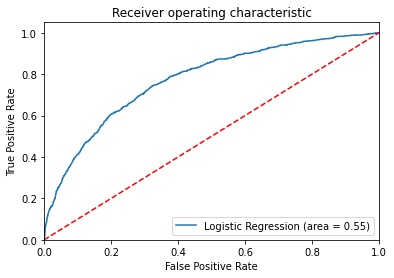

In [50]:
#ROC curve for untransformed dataset
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, xGmodel2.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xGmodel2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

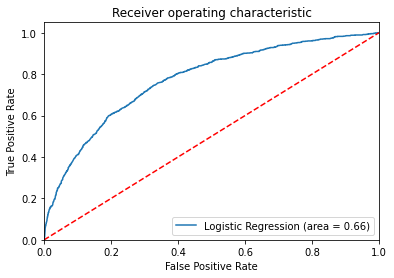

In [51]:
#ROC Curve for Logistic Regression on SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, xGmodel.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xGmodel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [52]:
print('F-Score for SMOTE model', f1_score(y_test, y_pred_test))
print('F-Score for untransformed model', f1_score(y_test, y_untrans_pred))

F-Score for SMOTE model 0.3595194085027726
F-Score for untransformed model 0.18046511627906975


In [53]:
#website for us to compare xG results with: https://understat.com/league/EPL/2017

In [54]:
#nontransformed dataset random forest
clf2 = RandomForestClassifier(random_state=0, oob_score = True, max_depth = 5, n_estimators = 500)
clf2.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=500, oob_score=True,
                       random_state=0)

In [55]:
y_pred_forest_train_2 = clf2.predict(X_train)
y_pred_forest_test_2 = clf2.predict(X_test)
print(clf2.feature_importances_)
print(classification_report(y_test, y_pred_forest_test_2))

[0.56077769 0.34588909 0.01635592 0.0769773 ]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      8137
           1       0.60      0.10      0.17       907

    accuracy                           0.90      9044
   macro avg       0.75      0.55      0.56      9044
weighted avg       0.88      0.90      0.87      9044



In [56]:
clf = RandomForestClassifier(random_state=0, oob_score = True, max_depth = 7)
clf.fit(X_over, y_over)

RandomForestClassifier(max_depth=7, oob_score=True, random_state=0)

In [57]:
y_pred_forest_train = clf.predict(X_train)
y_pred_forest_test = clf.predict(X_test)

In [58]:
#X = shots[[]'distance_m', 'angle','strong_foot', 'header']]
clf.feature_importances_

array([0.58294607, 0.33735113, 0.01685299, 0.06284981])

In [59]:
print('Accuracy of random forest classifier on training set: {:.2f}'.format(clf.score(X_over, y_over)))
print('Accuracy of random forest classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
print('OOB score of random forest classifier on training set: {:.2f}'.format(clf.oob_score_))
print('OOB score of random forest classifier on test set: {:.2f}'.format(clf.oob_score_))

Accuracy of random forest classifier on training set: 0.75
Accuracy of random forest classifier on test set: 0.84
OOB score of random forest classifier on training set: 0.75
OOB score of random forest classifier on test set: 0.75


In [60]:
print(classification_report(y_test, y_pred_forest_test))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91      8137
           1       0.31      0.45      0.37       907

    accuracy                           0.84      9044
   macro avg       0.62      0.67      0.64      9044
weighted avg       0.87      0.84      0.86      9044



In [61]:
print(confusion_matrix(y_test, y_pred_forest_test))

[[7215  922]
 [ 498  409]]


In [62]:
#See if there is change in OOB Score
for i in range(30, 150, 10):
    rand_for = RandomForestClassifier(random_state=0, oob_score = True, max_depth = 5, n_estimators = i)
    rand_for.fit(X_over, y_over)
    print(rand_for.oob_score_)

0.7424188369603996
0.7430774719394055
0.7426658250775269
0.7435440050495349
0.7440654244079146
0.7438458794149126
0.7436263344219106
0.7438458794149126
0.7437909931666621
0.7436537775460358
0.7442026400285409
0.7440928675320398


In [63]:
#Get performance metrics for various maximum depths
depth_dict = {}
for i in range(3, 21):
    rand_for = RandomForestClassifier(random_state=0, oob_score = True, max_depth = i)
    rand_for.fit(X_over, y_over)
    print('training acc for', i, rand_for.score(X_over, y_over))
    print('test acc for', i, rand_for.score(X_test, y_test))
    print('feature importances are', rand_for.feature_importances_)
    print(classification_report(y_test, rand_for.predict(X_test)))
    print(classification_report(y_test, rand_for.predict(X_test), output_dict = True)['1']['recall'])
    depth_dict[i] = {}
    depth_dict[i]['recall'] = [i, classification_report(y_test, rand_for.predict(X_test), output_dict = True)
                               ['1']['recall']]
    depth_dict[i]['f-score'] = [i, classification_report(y_test, rand_for.predict(X_test), output_dict = True)
                               ['1']['f1-score']]
    depth_dict[i]['test_acc'] = [i, rand_for.score(X_test, y_test)]

training acc for 3 0.734899420950081
test acc for 3 0.8717381689517912
feature importances are [0.5905754  0.35015914 0.01017671 0.04908875]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      8137
           1       0.35      0.32      0.33       907

    accuracy                           0.87      9044
   macro avg       0.64      0.62      0.63      9044
weighted avg       0.87      0.87      0.87      9044

0.3153252480705623
training acc for 4 0.7406624770163835
test acc for 4 0.8521671826625387
feature importances are [0.60288072 0.32602558 0.01283513 0.05825857]
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      8137
           1       0.32      0.41      0.36       907

    accuracy                           0.85      9044
   macro avg       0.62      0.65      0.64      9044
weighted avg       0.87      0.85      0.86      9044

0.40683572216097025
training acc for 5 0.746

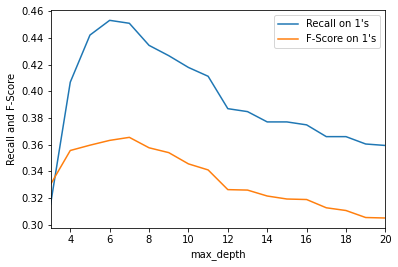

In [64]:
#Generate a graph showing how recall and f score vary with maximum depth
import matplotlib.pyplot as plt
xs = []
ys = []
xs_ = []
ys_ = []
for i in range(3, 21):
    xs.append(depth_dict[i]['recall'][0])
    ys.append(depth_dict[i]['recall'][1])
    xs_.append(depth_dict[i]['f-score'][0])
    ys_.append(depth_dict[i]['f-score'][1])

plt.plot(xs, ys, label = 'Recall on 1\'s')
plt.plot(xs_, ys_, label = 'F-Score on 1\'s')

plt.xlim(3, 20)
plt.xlabel("max_depth")
plt.ylabel("Recall and F-Score")
plt.legend(loc="upper right")
plt.show()

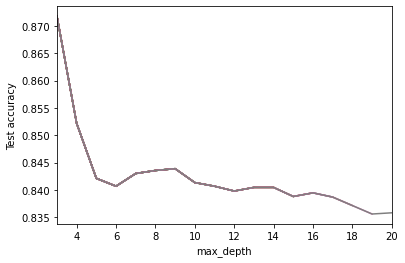

In [65]:
xs2 = []
ys2 = []
for i in range(3, 21):
    xs2.append(depth_dict[i]['test_acc'][0])
    ys2.append(depth_dict[i]['test_acc'][1])
    plt.plot(xs2, ys2)

plt.xlim(3, 20)
plt.xlabel("max_depth")
plt.ylabel("Test accuracy")
plt.show()

In [66]:
from sklearn.svm import SVC
svc = SVC(C = 0.01, kernel = 'rbf', gamma = 'auto')
svc.fit(X_over, y_over)

SVC(C=0.01, gamma='auto')

In [67]:
y_pred_test_SVM = svc.predict(X_test)

In [68]:
print('Accuracy of non-linear SVM SMOTE classifier on training set: {:.2f}'.format(svc.score(X_over, y_over)))
print('Accuracy of non-linear SVM SMOTE classifier on test set: {:.2f}'.format(svc.score(X_test, y_test)))

Accuracy of non-linear SVM SMOTE classifier on training set: 0.74
Accuracy of non-linear SVM SMOTE classifier on test set: 0.87


In [69]:
print(classification_report(y_test, y_pred_test_SVM))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      8137
           1       0.34      0.34      0.34       907

    accuracy                           0.87      9044
   macro avg       0.63      0.63      0.63      9044
weighted avg       0.87      0.87      0.87      9044



In [70]:
confusion_matrix_SVM = confusion_matrix(y_test, y_pred_test_SVM)
print(confusion_matrix_SVM)

[[7538  599]
 [ 597  310]]


In [71]:
#Tuning the SVM regularization parameter
#train_accs = []
#test_accs = []
#f_scores = []
#for reg_param in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    #svc_tune = SVC(C = reg_param)
    #svc_tune.fit(X_over, y_over)
    #y_pred_test_SVM = svc_tune.predict(X_test)
    #train_acc = svc_tune.score(X_over, y_over)
    #test_acc = svc_tune.score(X_test, y_test)
    #f_score = f1_score(y_test, y_pred_test_SVM)
    #train_accs.append(train_acc)
    #test_accs.append(test_acc)
    #f_scores.append(f_score)
    #print('done')

In [72]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(random_state=1, hidden_layer_sizes = (100,100), activation = 'logistic', max_iter = 200)
MLP.fit(X_over, y_over)

MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 100),
              random_state=1)

In [73]:
y_pred_MLP_test = MLP.predict(X_test)

In [74]:
print('Accuracy of MLP classifier on training set: {:.2f}'.format(MLP.score(X_over, y_over)))
print('Accuracy of MLP classifier on test set: {:.2f}'.format(MLP.score(X_test, y_test)))

Accuracy of MLP classifier on training set: 0.74
Accuracy of MLP classifier on test set: 0.85


In [75]:
print(classification_report(y_test, y_pred_MLP_test))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      8137
           1       0.32      0.40      0.36       907

    accuracy                           0.85      9044
   macro avg       0.63      0.65      0.64      9044
weighted avg       0.87      0.85      0.86      9044



In [76]:
confusion_mat_MLP = confusion_matrix(y_test, y_pred_MLP_test)
print(confusion_mat_MLP)

[[7358  779]
 [ 540  367]]


In [77]:
MLP.n_layers_

4

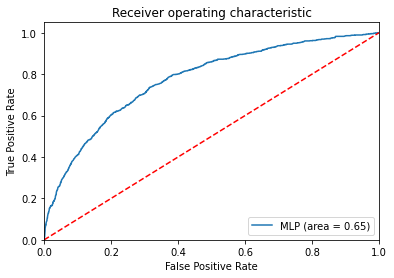

In [78]:
#ROC curve for untransformed dataset
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
MLP_roc_auc = roc_auc_score(y_test, MLP.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, MLP.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='MLP (area = %0.2f)' % MLP_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [79]:
MLP_dict = {}
for i in range(1, 6):
    hidden_layers = tuple([100]*i)
    MLP_inst = MLPClassifier(random_state=1, hidden_layer_sizes = hidden_layers, activation = 'logistic')
    MLP_inst.fit(X_over, y_over)
    print('training acc for', i, MLP_inst.score(X_over, y_over))
    print('test acc for', i, MLP_inst.score(X_test, y_test))
    print(classification_report(y_test, MLP_inst.predict(X_test)))
    print(classification_report(y_test, MLP_inst.predict(X_test), output_dict = True)['1']['recall'])
    print('This NN has', )
    MLP_dict[i] = {}
    MLP_dict[i]['recall'] = [i, classification_report(y_test, MLP_inst.predict(X_test), output_dict = True)
                               ['1']['recall']]
    MLP_dict[i]['f-score'] = [i, classification_report(y_test, MLP_inst.predict(X_test), output_dict = True)
                               ['1']['f1-score']]
    MLP_dict[i]['test_acc'] = [i, MLP_inst.score(X_test, y_test)]

training acc for 1 0.7404429320233815
test acc for 1 0.8402255639097744
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      8137
           1       0.30      0.46      0.36       907

    accuracy                           0.84      9044
   macro avg       0.62      0.67      0.64      9044
weighted avg       0.87      0.84      0.85      9044

0.4564498346196251
This NN has
training acc for 2 0.7382749252174867
test acc for 2 0.8541574524546661
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      8137
           1       0.32      0.40      0.36       907

    accuracy                           0.85      9044
   macro avg       0.63      0.65      0.64      9044
weighted avg       0.87      0.85      0.86      9044

0.4046306504961411
This NN has
training acc for 3 0.7399215126650018
test acc for 3 0.8388987173816895
              precision    recall  f1-score   support

           0 

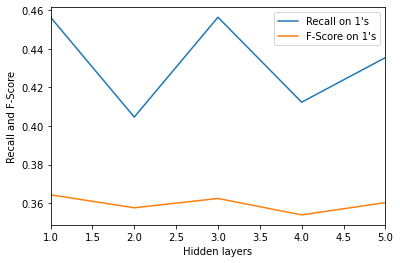

In [80]:
import matplotlib.pyplot as plt
xs = []
ys = []
xs_ = []
ys_ = []
for i in range(1, 6):
    xs.append(MLP_dict[i]['recall'][0])
    ys.append(MLP_dict[i]['recall'][1])
    xs_.append(MLP_dict[i]['f-score'][0])
    ys_.append(MLP_dict[i]['f-score'][1])

plt.plot(xs, ys, label = 'Recall on 1\'s')
plt.plot(xs_, ys_, label = 'F-Score on 1\'s')

plt.xlim(1, 5)
plt.xlabel("Hidden layers")
plt.ylabel("Recall and F-Score")
plt.legend(loc="upper right")
plt.show()

0.8402255639097744
0.8541574524546661
0.8388987173816895
0.8489606368863335
0.8448695267580717


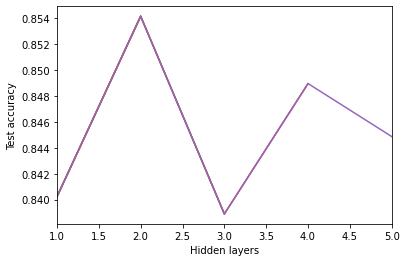

In [81]:
xs2 = []
ys2 = []
for i in range(1, 6):
    print(MLP_dict[i]['test_acc'][1])
    xs2.append(MLP_dict[i]['test_acc'][0])
    ys2.append(MLP_dict[i]['test_acc'][1])
    plt.plot(xs2, ys2)

plt.xlim(1, 5)
plt.xlabel("Hidden layers")
plt.ylabel("Test accuracy")
plt.show()

In [82]:
#can give the probability any shot ends up in a goal for our dataset as the predicted probability of a 1
#instance
shots['xGSMOTE'] = [x[1] for x in xGmodel.predict_proba(X)]
shots['xGnonSMOTE'] = [x[1] for x in xGmodel2.predict_proba(X)]
shots['xGSMOTEForest'] = [x[1] for x in clf.predict_proba(X)]
shots['xGnonSMOTEForest'] = [x[1] for x in clf2.predict_proba(X)]

In [83]:
#This says Arsenal's xG for the season is around 164 which is basically double what it actually was
#Our model is grossly overpredicting when using SMOTE
#The sum of xG seems to make a lot more sense without SMOTE, especially when taking into account that there seems
#to be missing values in the dataset
Arsenalshots = shots[shots['teamId'] == 1609] 
print('Arsenal actual goals in this dataset is:', len(Arsenalshots[Arsenalshots['goal'] == 1]))
print('xG sum with untransformed dataset is:',sum(shots[shots['teamId'] == 1609]['xGnonSMOTE']))
print('xG sum with SMOTE transformed dataset and logistic classifier is:',
      sum(shots[shots['teamId'] == 1609]['xGSMOTE']))
print('xG sum with SMOTE transformed dataset and random forest classifier is:',
      sum(shots[shots['teamId'] == 1609]['xGSMOTEForest']))
print('xG sum with untransformed dataset and random forest classifier is:',
      sum(shots[shots['teamId'] == 1609]['xGnonSMOTEForest']))

Arsenal actual goals in this dataset is: 69
xG sum with untransformed dataset is: 62.475192659234274
xG sum with SMOTE transformed dataset and logistic classifier is: 165.97755578841668
xG sum with SMOTE transformed dataset and random forest classifier is: 161.31107583210414
xG sum with untransformed dataset and random forest classifier is: 61.53296409372054


In [84]:
#It seems that we are missing some goals for Arsenal, as they actually scored 74 goals in this season
#But I really think I parsed the tags correctly??
#They must have been merged out when we lost all of that data with the stadium names, although that doesnt make too
#much sense because there are still 38 games present for Arsenal
#In order for this analysis I should also merge the teams dataset
#I genuinely think its just missing some data points, which is really too bad
Arsenalshots = shots[shots['teamId'] == 1609]
len(Arsenalshots[Arsenalshots['goal'] == 1])

69

In [85]:
playergoals = pd.DataFrame()

In [86]:
#create a dataset of players to see how their summed up xG compares to how many actual
#goals they scored
names = []
player_team = []
goals_scored = []
xGnorm = []
SMOTExG = []
ForestxG = []
ForestnonSMOTExG = []
for name in shots['shortName'].unique():
    names.append(name)
    playerdf = shots[shots['shortName'] == name]
    team_name = shots[shots['shortName'] == name]['officialName'].unique()
    player_team.append(team_name)
    goals1 = len(playerdf[playerdf['goal'] == 1])
    goals_scored.append(goals1)
    xGsum1 = sum(playerdf['xGnonSMOTE'])
    xGnorm.append(xGsum1)
    xGsum2 = sum(playerdf['xGSMOTE'])
    SMOTExG.append(xGsum2)
    xGsum3 = sum(playerdf['xGSMOTEForest'])
    ForestxG.append(xGsum3)
    xGsum4 = sum(playerdf['xGnonSMOTEForest'])
    ForestnonSMOTExG.append(xGsum4)
playergoals['name'] = names
playergoals['actual_goals'] = goals_scored
playergoals['OG_xG'] = xGnorm
playergoals['SMOTExG'] = SMOTExG
playergoals['ForestxG'] = ForestxG
playergoals['ForestnonSMOTExG'] = ForestnonSMOTExG
playergoals['Team'] = player_team

In [87]:
#Take difference between goals and xG
playergoals['Goals - xG'] = playergoals['actual_goals'] - playergoals['OG_xG']
playergoals['Goals - SMOTExG'] = playergoals['actual_goals'] - playergoals['SMOTExG']

In [88]:
print(playergoals['Goals - xG'].mean())
print(playergoals['Goals - SMOTExG'].mean())

-0.017944049393446758
-3.1594838359224364


In [89]:
#Take players who have highest difference between goals and expected goals
playergoals[playergoals['Goals - xG'] > 6][['name', 'actual_goals', 'OG_xG', 'SMOTExG', 'Team', 'Goals - xG']]

,name,actual_goals,OG_xG,SMOTExG,Team,Goals - xG
131,Son Heung-Min,14,7.624879,22.160942,"[Tottenham Hotspur FC, Korea Republic]",6.375121
209,Mohamed Salah,32,18.918801,51.502319,"[Liverpool FC, Egypt]",13.081199
212,Philippe Coutinho,15,7.559778,22.007417,"[Liverpool FC, FC Barcelona, Brazil]",7.440222
543,Iago Aspas,20,13.432278,32.400224,"[Spain, Real Club Celta de Vigo]",6.567722
667,A. Griezmann,22,10.921191,29.762276,"[France, Club Atl\u00e9tico de Madrid]",11.078809
951,M. Icardi,23,15.426999,37.062485,[FC Internazionale Milano],7.573001
1019,L. Messi,27,19.199246,52.436431,"[FC Barcelona, Argentina]",7.800754
1084,Rony Lopes,15,7.368457,19.069079,[AS Monaco FC],7.631543
1090,R. Falcao,16,9.527941,22.980535,"[AS Monaco FC, Colombia]",6.472059
1128,E. Cavani,27,19.834030,45.550341,"[Paris Saint-Germain FC, Uruguay]",7.165970


In [90]:
teamgoals = pd.DataFrame()

In [91]:
shots['officialName']

0        Arsenal FC
1        Arsenal FC
2        Arsenal FC
3        Arsenal FC
4        Arsenal FC
            ...    
36169        Panama
36170        Panama
36171        Panama
36172        Panama
36173        Panama
Name: officialName, Length: 36174, dtype: object

In [92]:
#Do the same with teams as you just did with players
teamnames = []
goals_scored = []
xGnorm = []
SMOTExG = []
ForestxG = []
ForestnonSMOTExG = []
for name in shots['officialName'].unique():
    teamnames.append(name)
    teamdf = shots[shots['officialName'] == name]
    goals1 = len(teamdf[teamdf['goal'] == 1])
    goals_scored.append(goals1)
    xGsum1 = sum(teamdf['xGnonSMOTE'])
    xGnorm.append(xGsum1)
    xGsum2 = sum(teamdf['xGSMOTE'])
    SMOTExG.append(xGsum2)
    xGsum3 = sum(teamdf['xGSMOTEForest'])
    ForestxG.append(xGsum3)
    xGsum4 = sum(teamdf['xGnonSMOTEForest'])
    ForestnonSMOTExG.append(xGsum4)
teamgoals['Team'] = teamnames
teamgoals['actual_goals'] = goals_scored
teamgoals['OG_xG'] = xGnorm
teamgoals['SMOTExG'] = SMOTExG
teamgoals['ForestxG'] = ForestxG
teamgoals['ForestnonSMOTExG'] = ForestnonSMOTExG

In [93]:
teamgoals['Goals - xG'] = teamgoals['actual_goals'] - teamgoals['OG_xG']
teamgoals['Goals - SMOTExG'] = teamgoals['actual_goals'] - teamgoals['SMOTExG']

In [94]:
print(teamgoals['Goals - SMOTExG'].mean())
print(teamgoals['Goals - xG'].mean())

-52.0805238760118
-0.29578739484035566


In [95]:
kernels = ['RBF', 'Sigmoid','Linear', 'Polynomial']

#A function which returns the corresponding SVC model
def getClassifier(ktype):
    if ktype == 0:
        return SVC(kernel='rbf', gamma="auto") 
    elif ktype == 1:
        return SVC(kernel='sigmoid', gamma="auto")
    elif ktype == 2:
        return SVC(kernel='linear', gamma="auto")
    elif ktype == 3:
        return SVC(kernel='poly', degree=3, gamma="auto")

In [96]:
#Find which kernel performs best, seems to be RBF
for i in range(4):
    SVclassifier = getClassifier(i)
    SVclassifier.fit(X_over, y_over)
    y_pred = SVclassifier.predict(X_test)
    print("Evaluation of", kernels[i], "kernel:")
    print(classification_report(y_test, y_pred))

Evaluation of RBF kernel:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      8137
           1       0.32      0.39      0.35       907

    accuracy                           0.86      9044
   macro avg       0.63      0.65      0.64      9044
weighted avg       0.87      0.86      0.86      9044

Evaluation of Sigmoid kernel:
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      8137
           1       0.15      0.46      0.23       907

    accuracy                           0.68      9044
   macro avg       0.54      0.58      0.51      9044
weighted avg       0.84      0.68      0.74      9044

Evaluation of Linear kernel:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      8137
           1       0.33      0.34      0.33       907

    accuracy                           0.87      9044
   macro avg       0.63      0.63      0.63